# 泰坦尼克号生还率探究 

# 一、数据集概览

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [57]:
filename = 'titanic-data.csv'
titanic_df = pd.read_csv(filename) # 读取文件

In [58]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


观察数据的前5条，对整个数据有一个初步的熟悉和判断：  
1.PassengerID：是每个乘客的唯一编号，应该与本研究关系不大  
2.Survived：0代表死亡，1代表获救  
3.Pclass：代表乘客的舱位等级，1代表头等舱，2代表二等舱，3代表三等舱，舱位等级与乘客的经济条件和社会地位有较为紧密的联系，rich first？  
4.Name：乘客的名字，应该与本研究关系不大  
5.Sex：乘客的性别，male代表男性，female代表女性，lady first？  
6.Age：乘客的年龄，children and old first？  
7.SibSp：与乘客共同乘船的兄弟姐妹个数，数量多的有可能生还概率大？  
8.Parch：与乘客共同乘船的直系亲属（父母、孩子）个数，有可能增大获救概率？  
9.Ticket：船票信息，应该与本研究关系不大  
10.Fare：船票价格，因上船的位置和舱位等级而异  
11.Cabin：客舱号，且缺失值较多  
12.Embarked：登船地点，有S、C、Q三个位置  

In [59]:
titanic_df.info() # 观察源数据的基本信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


共有891条数据，其中'age' 、 'Cabin' 及 'Embarked' 等属性存在数据缺失情况

In [60]:
titanic_df.describe() # 观察数据的统计描述

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


根据数据集的统计描述，大致可得到以下推论：   
1.大约0.384比例的人数获救
2.舱位平均等级约2.31，表明大部分人处于三等舱   
3.乘客的平均年龄约为29.70岁，最小年龄0.42岁，最大年龄80岁   
4.平均每名乘客约有0.52名兄弟姐妹同船，最少的肚子登船，最多的有8名兄弟姐妹同船   
5.平均每名乘客约有0.38名直系亲属（包含继父母、子女等情况）同船   
6.船票的平均价格为32.2刀，最贵的512.33刀，最便宜的7.91刀   

### 通过对整个数据集的概览，拟对以下几个问题进行探究：  
1.舱位等级与乘客生还率的关系  
2.性别与乘客生还率的关系  
3.年龄与乘客生还率的关系  
4.不同舱位等级情况下男性与女性的乘客生还情况

# 二、缺失值处理

## 1.对 “age” 属性缺失值的处理

本案例中缺失值处理方法主要参考了知乎问题《机器学习中如何处理缺失数据？》中 pro-am 作者的回答，采用随机森林算法拟合填充。
（网页链接：https://www.zhihu.com/question/26639110）

In [61]:
age_df = titanic_df[['Age','Pclass','SibSp','Parch']]
age_df.head()

,Age,Pclass,SibSp,Parch
0,22.0,3,1,0
1,38.0,1,1,0
2,26.0,3,0,0
3,35.0,1,1,0
4,35.0,3,0,0


In [62]:
from sklearn.ensemble import RandomForestRegressor
# 定义age属性缺失值预测填充函数
def set_missing_age(df):
    # 把已有的数值型特征提取出来，放入随机森林模型
    age_df = df[['Age','Fare','Parch','SibSp','Pclass']]
    
    # 将乘客分成已知Age和未知Age两部分
    age_known = age_df[age_df.Age.notnull()].as_matrix()
    age_unknown = age_df[age_df.Age.isnull()].as_matrix()
    
    # X为特征属性值，去掉 age column
    X = age_known[:, 1:]
    
    # y为结果标签值，本例中即为与特征属性值对应的 age column
    y = age_known[:, 0]
    
    # fit到Random Forest Regressor中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X,y)
    
    # 用得到的模型进行未知特征值预测
    age_predicted = rfr.predict(age_unknown[:,1:])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.Age.isnull()), 'Age'] = age_predicted
    
    return df, rfr

titanic_df, rfr = set_missing_age(titanic_df)

## 2.对“Cabin”属性缺失值的处理

由于“Cabin”属性缺失值较多，达到687条，故直接Pass掉不使用本属性。

# 3.对“Embarked”属性数据缺失的处理

In [63]:
titanic_df.loc[(titanic_df.Embarked.isnull())]
# 观察缺失值条目，发现Embarked缺失乘客的Pclass=1，Fare=80
# 这里发现一个奇怪的地方，两个人Ticket的号码是相同的，我又去看了一下原数据集，发现Ticket号码的重复值非常多
# 由于Ticket与本例的研究关联性不大，所以暂且认为数据都是准确的

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [64]:
titanic_df.loc[(titanic_df.Fare > 75)
               &(titanic_df.Fare < 85)
               &(titanic_df.Pclass == 1)]
# 观察与缺失值舱位等级相同且票价相差不大的其他乘客的登船点

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.000000,1,0,PC 17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000000,1,0,PC 17572,76.7292,D33,C
61,62,1,1,"Icard, Miss. Amelie",female,38.000000,0,0,113572,80.0000,B28,NaN
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.000000,1,0,36973,83.4750,C83,S
102,103,0,1,"White, Mr. Richard Frasar",male,21.000000,0,1,35281,77.2875,D26,S
124,125,0,1,"White, Mr. Percival Wayland",male,54.000000,0,1,35281,77.2875,D26,S
139,140,0,1,"Giglio, Mr. Victor",male,24.000000,0,0,PC 17593,79.2000,B86,C
218,219,1,1,"Bazzani, Miss. Albina",female,32.000000,0,0,11813,76.2917,D15,C
230,231,1,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.000000,1,0,36973,83.4750,C83,S
256,257,1,1,"Thorne, Mrs. Gertrude Maybelle",female,34.620286,0,0,PC 17585,79.2000,NaN,C


通过观察发现，头等舱且票价在80刀左右的都是在S或C登船，并且在C点登船的人Ticket号码位数几乎均为5位，而缺失值的Ticket号码位数为6位，较为符合S点登船的乘客Ticket号码的特点，故两个缺失值全部手工填补为“S”。

In [65]:
titanic_df.loc[(titanic_df.Embarked.isnull()), 'Embarked'] = ["S", "S"]

In [66]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [67]:
# 将数据全部填补完成的文件另存
titanic_df.to_csv("new-titanic-data.csv")

# 三、探索数据集

In [68]:
# 定义打印柱形图函数
def print_bar(data, title, xlabel, ylabel):
    data.plot(kind = 'bar')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)

Survived
0    549
1    342
Name: Survived, dtype: int64


([<matplotlib.patches.Wedge at 0x10dc0dcd0>,
  <matplotlib.text.Text at 0x10dc535d0>])

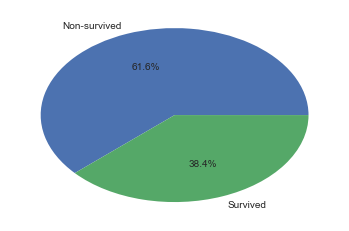

In [69]:
# 先查看乘客的整体获救情况
Survived_count = titanic_df.groupby('Survived')['Survived'].count()
print Survived_count
plt.pie(Survived_count, labels = ['Non-survived', 'Survived'],
       autopct = '%.1f%%')

整体来看，样本中的891位乘客，有342位获救，约占样本总数的38.4%

## 1.舱位等级（Pclass）与乘客获救情况

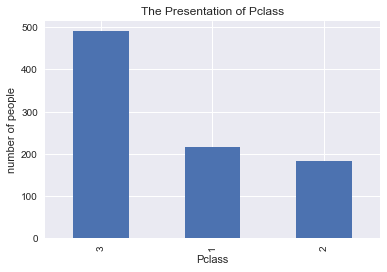

In [70]:
# 不同舱位等级的乘客分布数量
print_bar(titanic_df.Pclass.value_counts(),
         'The Presentation of Pclass',  # title
         'Pclass',                      # xlabel
         'number of people')            # ylabel

从图中看出，三等舱人数最多，头等舱与二等舱人数不及三等舱的一半，二等舱人数最少。

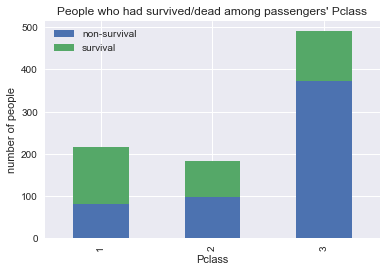

In [71]:
# 不同舱位等级乘客的获救情况
Pclass_death = titanic_df.Pclass[titanic_df.Survived == 0].value_counts()
Pclass_survival = titanic_df.Pclass[titanic_df.Survived == 1].value_counts()
df_Pclass = pd.DataFrame({
    'non-survival': Pclass_death,
    'survival': Pclass_survival
})
df_Pclass.plot(kind = 'bar', stacked = True) # stacked = True 采用堆积柱形图
plt.title("People who had survived/dead among passengers' Pclass")
plt.xlabel("Pclass")
plt.ylabel("number of people")
plt.show()

从图中可以看出，头等舱和二等舱的获救比例明显高于三等舱，下面再来看下具体的获救数量和比例。

In [72]:
Pclass_death

3    372
2     97
1     80
Name: Pclass, dtype: int64

In [73]:
Pclass_survival

1    136
3    119
2     87
Name: Pclass, dtype: int64

In [74]:
Pclass_death + Pclass_survival

1    216
2    184
3    491
Name: Pclass, dtype: int64

1    0.629630
2    0.472826
3    0.242363
Name: Pclass, dtype: float64

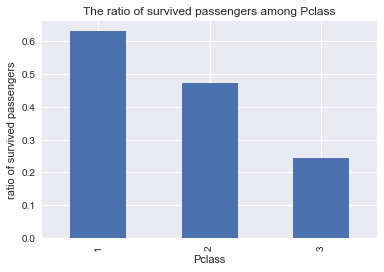

In [75]:
Pclass_ratio = Pclass_survival.div(Pclass_death + Pclass_survival)
print_bar(Pclass_ratio,
         'The ratio of survived passengers among Pclass',
         'Pclass',
         'ratio of survived passengers')
Pclass_ratio

头等舱共有216人，获救人数为136人，获救比例约62.93%  
二等舱共有184人，获救人数为87人，获救比例约47.28%  
三等舱共有491人，获救人数为119人，获救比例约24.24%  
### 仅从本数据来看，明显舱位等级越高的乘客获救比例较高。舱位等级与乘客在社会中的经济能力及社会地位有关系，所以在泰坦尼克号出现事故后，很可能是优先救助rich people，毕竟随机救助的话不太可能出现目前这样的比例情况。

## 2.性别（Sex）与乘客的获救情况

male      577
female    314
Name: Sex, dtype: int64


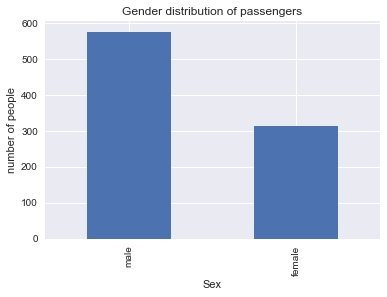

In [76]:
# 看看乘客的性别分布情况
print titanic_df.Sex.value_counts()
print_bar(titanic_df.Sex.value_counts(),
         'Gender distribution of passengers',
         'Sex',
         'number of people')

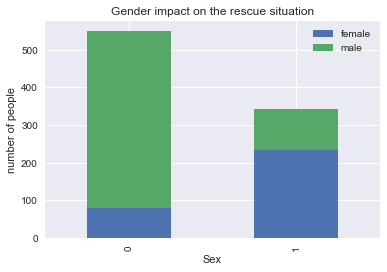

In [77]:
# 看看不同性别的获救情况
Survived_male = titanic_df.Survived[titanic_df.Sex == 'male'].value_counts()
Survived_female = titanic_df.Survived[titanic_df.Sex == 'female'].value_counts()
df_Sex = pd.DataFrame({
    'male': Survived_male,
    'female': Survived_female

})
df_Sex.plot(kind = 'bar', stacked = True)
plt.title("Gender impact on the rescue situation")
plt.xlabel("Sex")
plt.ylabel("number of people")
plt.show()

In [78]:
Survived_male.div((Survived_male + Survived_female))

0    0.852459
1    0.318713
Name: Survived, dtype: float64

In [79]:
Survived_female.div((Survived_male + Survived_female))

0    0.147541
1    0.681287
Name: Survived, dtype: float64

### 在本样本中，共有891名乘客，其中男性乘客577名，获救比例为31.87%；女性乘客314名，获救比例为68.13%。基本可以推断，性别对是否获救具有影响。总体而言，lady first。

## 3.年龄（Age）与乘客获救情况

探究年龄与乘客获救关系时，考虑将Age离散化，分成4个年龄段，分别考虑获救情况：  
child：0-16岁  
youth：17-30岁  
mature：31-60岁  
old：61岁以上  

In [80]:
bins = np.array([0,17,31,61,81]) # 乘客中年龄最大的为80岁
titanic_df['Age_group'] = pd.cut(titanic_df['Age'], bins)
age_grouped = titanic_df.groupby(titanic_df['Age_group'])
age_survival_ratio = (age_grouped.sum() / age_grouped.count())['Survived']

Age_group
(0, 17]     127
(17, 31]    410
(31, 61]    335
(61, 81]     19
Name: PassengerId, dtype: int64


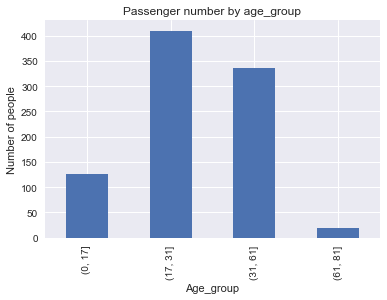

In [81]:
# 观察各年龄段的乘客人数
age_grouped.count()['PassengerId'].plot(kind = 'bar', stacked = True)
plt.title('Passenger number by age_group')
plt.xlabel('Age_group')
plt.ylabel('Number of people')
print age_grouped.count()['PassengerId']

本样本中：  
child组(0-16岁)共有127名乘客  
youth组(17-30岁）共有410名乘客  
mature组（31-60岁）共有335名乘客  
old组（61岁以上）共有19名乘客

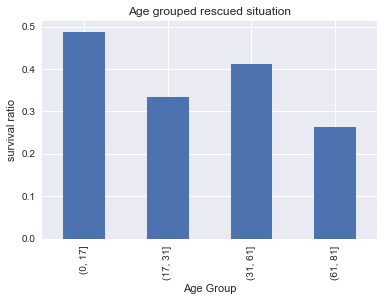

In [82]:
print_bar(age_survival_ratio,
          "Age grouped rescued situation",
          "Age Group",
          "survival ratio")

### 从各年龄段的存活率来看，child组的存活率要高于其他组别，分析原因一是优先救助儿童，二是儿童通常与父母同船，受到亲人的保护。

## 4.各舱位等级情况下不同性别的获救情况

Sex     female  male
Pclass              
1           94   122
2           76   108
3          144   347


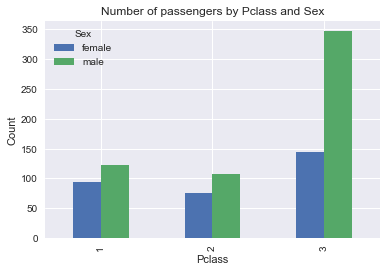

In [98]:
titanic_df.groupby(['Pclass', 'Sex']).count()['PassengerId'].unstack().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Number of passengers by Pclass and Sex')
passenger_by_Pclass_and_Sex = titanic_df.groupby(['Pclass', 'Sex']).count()['PassengerId'].unstack()
print passenger_by_Pclass_and_Sex

头等舱的女性有94人，男性有122人  
二等舱的女性有76人，男性有108人  
三等舱的女性有144人，男性有347人

Sex     female  male
Pclass              
1           91    45
2           70    17
3           72    47


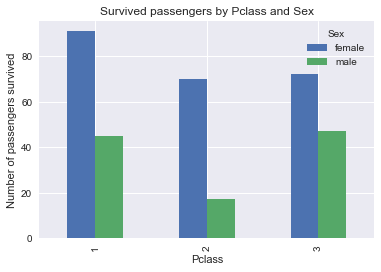

In [102]:
titanic_df.groupby(['Pclass', 'Sex']).sum()['Survived'].unstack().plot(kind = 'bar')
plt.ylabel('Number of passengers survived')
plt.title('Survived passengers by Pclass and Sex')
survived_passenger_by_Pclass_and_Sex = titanic_df.groupby(['Pclass', 'Sex']).sum()['Survived'].unstack()
print survived_passenger_by_Pclass_and_Sex

头等舱的女性生还91人，男性生还45人  
二等舱的女性生还70人，男性生还17人  
三等舱的女性生还72人，男性生还47人  

Sex       female      male
Pclass                    
1       0.968085  0.368852
2       0.921053  0.157407
3       0.500000  0.135447


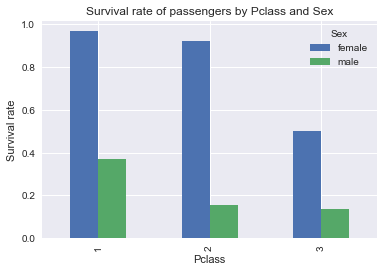

In [105]:
# 最后再来看一下不同舱位男性与女性的生还率
Survival_rate_by_Pclass_and_Sex = survived_passenger_by_Pclass_and_Sex / passenger_by_Pclass_and_Sex
print Survival_rate_by_Pclass_and_Sex
print_bar(Survival_rate_by_Pclass_and_Sex,
         'Survival rate of passengers by Pclass and Sex',
         'Pclass', 
         'Survival rate')  

### 从以上数据发现：  
### 对女性来说，头等舱和二等舱的女性生还率极高，均超过了90%，三等舱的女性生还率为50%；  
### 对男性来说，头等舱的男性生还率最高，达到36.89%，二等舱和三等舱的男性生还率相差较小，分别为15.74%和13.54%。

## 四、结论

### 通过以上分析可以发现，对生还与否影响较大的主要是性别因素，其次是舱位因素，年龄因素的影响主要体现在儿童的生还率要明显高于其他年龄段。

## 五、补充说明

### 1.可能影响生还率的其他因素

乘客的身体状况，乘客所处舱位距离救生艇的距离等等。

### 2.本分析的局限性

（1）本分析所呈现的结论，不能够说各因素导致了生还率的增大，只能说着重分析的几个因素与生还率具有一定的相关性。  
（2）结论并未使用统计方法进行显著性检验，所以无法拒绝该结果产生的偶然性。  
（3）本分析在填补‘Age’属性缺失值时使用了随机森林方法，而该方法被证明在噪声较大的分类或回归问题上会产生过拟合。因本分析未通过相关方法检测噪声情况，故无法判断随机森林方法填补‘Age’是否产生过拟合。  
（4）本样本容量891，kaggle上全部放出的数据总共1309条，所以通过本样本分析得出的结论在未经过统计显著性检验下无法代表全部总体的情况。